# Basic Policy Gradient

Lecture 15 | CMU ANLP Fall 2025 | Instructor: Sean Welleck

This notebook contains a simple policy gradient/REINFORCE example on the CartPole environment.

*Acknowledgements: code originally based on the example from the [pytorch repository](https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py)*

In [2]:
# !pip install "gymnasium[classic-control]"
import gymnasium as gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline

### 1. Environment

In [3]:
# Create the CartPole environment
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset(seed=42)
torch.manual_seed(42)

In [5]:
# State and action spaces
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("\nState is a vector of 4 numbers:")
print("  [cart position, cart velocity, pole angle, pole angular velocity]")

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)

State is a vector of 4 numbers:
  [cart position, cart velocity, pole angle, pole angular velocity]


Initial state: [-0.04058227  0.04756223  0.02611397  0.02860643]

Step 1:
  Action: 1 (RIGHT)
  Reward: 1.0
  Next state: [-0.03963102  0.24230015  0.0266861  -0.25572422]
  Done: False

Step 2:
  Action: 1 (RIGHT)
  Reward: 1.0
  Next state: [-0.03478502  0.43703112  0.02157161 -0.5398719 ]
  Done: False

Step 3:
  Action: 0 (LEFT)
  Reward: 1.0
  Next state: [-0.02604439  0.24161269  0.01077418 -0.24047087]
  Done: False


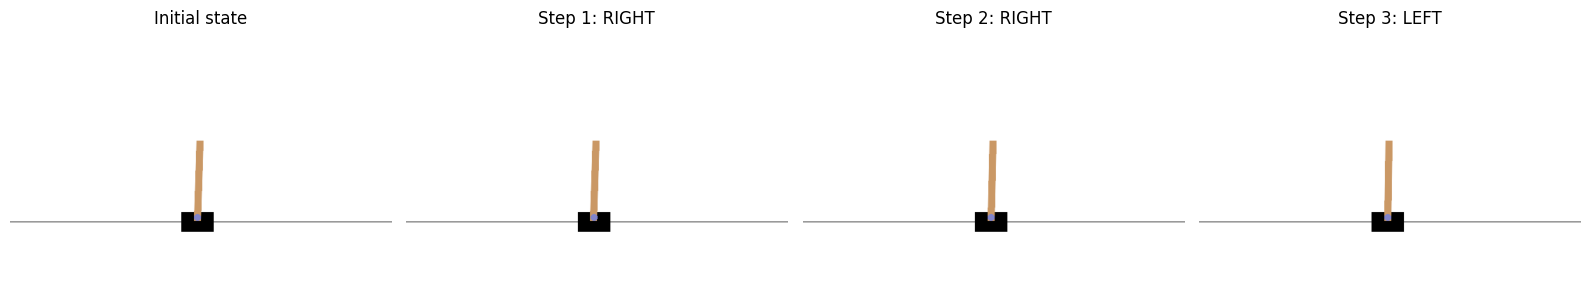

In [6]:
# See a few transitions with visualization
state, _ = env.reset()
print("Initial state:", state)

# Create a figure to show the transitions
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Show initial frame
axes[0].imshow(env.render())
axes[0].set_title('Initial state')
axes[0].axis('off')

for step in range(3):
    action = env.action_space.sample()  # Random action (0=left, 1=right)
    next_state, reward, terminated, truncated, _ = env.step(action)
    
    # Show frame after action
    axes[step + 1].imshow(env.render())
    axes[step + 1].set_title(f'Step {step+1}: {"LEFT" if action == 0 else "RIGHT"}')
    axes[step + 1].axis('off')
    
    print(f"\nStep {step+1}:")
    print(f"  Action: {action} ({'LEFT' if action == 0 else 'RIGHT'})")
    print(f"  Reward: {reward}")
    print(f"  Next state: {next_state}")
    print(f"  Done: {terminated or truncated}")
    
    state = next_state
    if terminated or truncated:
        break

plt.tight_layout()
plt.show()

We can see that a positive reward is given at each timestep.

Hence maximizing reward means keeping the cartpole upright for a longer time.

### 2. Policy Network

In [7]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.affine1(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

In [8]:
# See the policy give action probabilities for a sample state
policy = Policy()
state, _ = env.reset()
state_tensor = torch.from_numpy(state).float().unsqueeze(0)
probs = policy(state_tensor)
print("State:", state)
print("Action probabilities:", probs.detach().numpy()[0])
print(f"  P(LEFT) = {probs[0, 0].item():.3f}")
print(f"  P(RIGHT) = {probs[0, 1].item():.3f}")

State: [-0.03718864 -0.00496141 -0.0129202   0.0426765 ]
Action probabilities: [0.45581493 0.54418504]
  P(LEFT) = 0.456
  P(RIGHT) = 0.544


### 3. Training

In [9]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

running_reward = 10
num_episodes = 10000
max_steps_per_episode = 10000
log_interval = 10
running_reward = 10
discount_gamma = 0.99
EPS = np.finfo(np.float32).eps.item()

reward_history = []

for i_episode in range(num_episodes):
    state, _ = env.reset()
    ep_reward = 0

    # 1. Collect an episode trajectory
    log_probs, rewards = [], []
    for t in range(1, max_steps_per_episode):
        state = torch.tensor(state).unsqueeze(0)
        probs = policy(state)
        p = Categorical(probs)
        action = p.sample()
        log_prob = p.log_prob(action)

        state, reward, terminated, truncated, _ = env.step(action.item())

        log_probs.append(log_prob)
        rewards.append(reward)
        ep_reward += reward
        if terminated or truncated:
            break

    # 2. Compute returns
    returns = deque()
    R = 0
    for r in rewards[::-1]:
        R = r + discount_gamma * R
        returns.appendleft(R)
    returns = torch.tensor(returns)

    # 3. Compute loss
    log_probs = torch.cat(log_probs)
    policy_loss = -(log_probs*returns).sum()

    # 4. Update policy
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
    reward_history.append(running_reward)
    
    if i_episode % log_interval == 0:
        print(f'Episode {i_episode}\tLast reward: {ep_reward:.2f}\tAverage reward: {running_reward:.2f}')
    if running_reward > env.spec.reward_threshold:
        print(f"Solved! Running reward is now {running_reward} and the last episode runs to {t} time steps!")
        break

Episode 0	Last reward: 38.00	Average reward: 11.40
Episode 10	Last reward: 25.00	Average reward: 20.90
Episode 20	Last reward: 88.00	Average reward: 28.01
Episode 30	Last reward: 38.00	Average reward: 32.49
Episode 40	Last reward: 37.00	Average reward: 33.95
Episode 50	Last reward: 50.00	Average reward: 39.78
Episode 60	Last reward: 51.00	Average reward: 37.84
Episode 70	Last reward: 109.00	Average reward: 44.12
Episode 80	Last reward: 40.00	Average reward: 56.91
Episode 90	Last reward: 62.00	Average reward: 61.30
Episode 100	Last reward: 74.00	Average reward: 56.74
Episode 110	Last reward: 85.00	Average reward: 58.00
Episode 120	Last reward: 91.00	Average reward: 60.80
Episode 130	Last reward: 22.00	Average reward: 63.29
Episode 140	Last reward: 62.00	Average reward: 66.19
Episode 150	Last reward: 41.00	Average reward: 62.61
Episode 160	Last reward: 99.00	Average reward: 56.90
Episode 170	Last reward: 140.00	Average reward: 77.05
Episode 180	Last reward: 13.00	Average reward: 84.40
Ep

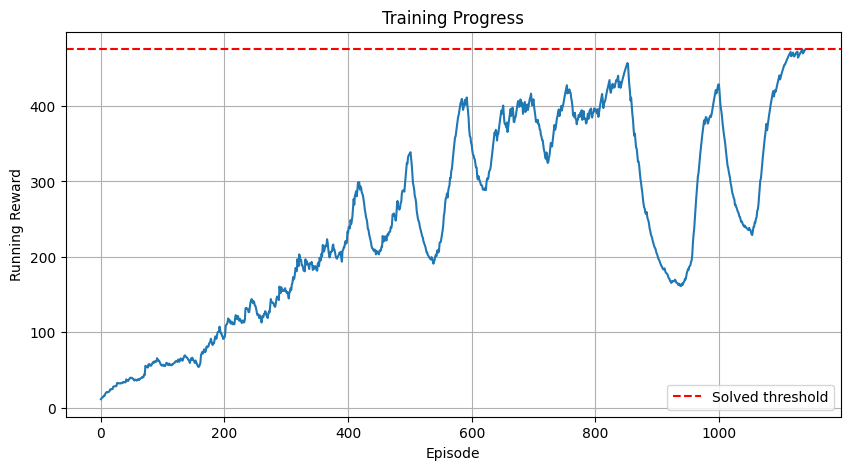

In [10]:
# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Running Reward')
plt.title('Training Progress')
plt.axhline(y=env.spec.reward_threshold, color='r', linestyle='--', label='Solved threshold')
plt.legend()
plt.grid(True)
plt.show()

### 4. Visualizing the Trained Agent

In [19]:
def create_animation(num_steps=200, use_greedy=True, show_actions=True):
    import base64
    from io import BytesIO
    from PIL import Image, ImageDraw, ImageFont
    import random
    
    state, _ = env.reset()
    frames = []
    actions_taken = []
    total_reward = 0
    
    for t in range(num_steps):
        with torch.no_grad():
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            probs = policy(state_tensor)
            if use_greedy:
                action = probs.argmax().item()
            else:
                m = Categorical(probs)
                action = m.sample().item()
        frames.append(env.render())
        actions_taken.append(action)
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        if terminated or truncated:
            break
    print(f"Episode: {len(frames)} steps, total reward: {total_reward:.1f}")
    
    # Convert frames to base64 encoded images with action overlay
    encoded_frames = []
    action_names = ["LEFT", "RIGHT"]
    
    for frame, action in zip(frames, actions_taken):
        img = Image.fromarray(frame)
        if show_actions:
            draw = ImageDraw.Draw(img)
            font = ImageFont.load_default(size=20)
            action_text = f"Action: {action_names[action]}"
            
            # Get text bounding box
            bbox = draw.textbbox((0, 0), action_text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]
            
            # Position in top right corner with padding
            padding = 10
            x = img.width - text_width - padding
            y = padding
            
            # Draw background rectangle
            bg_color = (50, 150, 50) if action == 1 else (150, 50, 50) 
            draw.rectangle(
                [x - 5, y - 5, x + text_width + 5, y + text_height + 5],
                fill=bg_color
            )
            draw.text((x, y), action_text, fill=(255, 255, 255), font=font)
        
        # Convert to base64
        buffer = BytesIO()
        img.save(buffer, format='PNG')
        encoded = base64.b64encode(buffer.getvalue()).decode()
        encoded_frames.append(encoded)
    
    # Generate unique ID for this animation
    unique_id = f"anim_{random.randint(100000, 999999)}"
    
    # Create HTML with JavaScript animation
    html = f"""
    <div id="{unique_id}_container" style="text-align: center;">
        <h3>CartPole Episode (Reward: {total_reward:.1f}, Steps: {len(frames)})</h3>
        <img id="{unique_id}_img" style="width: 500px; border: 2px solid #333; border-radius: 5px;"/>
        <br><br>
        <button id="{unique_id}_play_btn" style="padding: 10px 20px; font-size: 14px; margin: 5px;">▶️ Play/Pause</button>
        <button id="{unique_id}_reset_btn" style="padding: 10px 20px; font-size: 14px; margin: 5px;">↺ Reset</button>
        <span id="{unique_id}_info" style="margin-left: 20px; font-size: 16px;">Frame: 0/{len(frames)}</span>
        <br><br>
        <label for="{unique_id}_speed">Speed: </label>
        <input type="range" id="{unique_id}_speed" min="20" max="200" value="50" style="width: 300px;">
        <span id="{unique_id}_speed_val">50ms</span>
    </div>
    
    <script>
    (function() {{
        var frames = {encoded_frames};
        var currentFrame = 0;
        var playing = false;
        var interval = null;
        
        var img = document.getElementById('{unique_id}_img');
        var playBtn = document.getElementById('{unique_id}_play_btn');
        var resetBtn = document.getElementById('{unique_id}_reset_btn');
        var info = document.getElementById('{unique_id}_info');
        var speedSlider = document.getElementById('{unique_id}_speed');
        var speedVal = document.getElementById('{unique_id}_speed_val');
        
        function showFrame(n) {{
            currentFrame = n % frames.length;
            img.src = 'data:image/png;base64,' + frames[currentFrame];
            info.innerText = 'Frame: ' + currentFrame + '/{len(frames)}';
        }}
        
        function togglePlay() {{
            playing = !playing;
            if (playing) {{
                var speed = speedSlider.value;
                interval = setInterval(function() {{
                    currentFrame = (currentFrame + 1) % frames.length;
                    showFrame(currentFrame);
                }}, speed);
            }} else {{
                clearInterval(interval);
            }}
        }}
        
        function reset() {{
            playing = false;
            clearInterval(interval);
            currentFrame = 0;
            showFrame(0);
        }}
        
        // Event listeners
        playBtn.addEventListener('click', togglePlay);
        resetBtn.addEventListener('click', reset);
        
        speedSlider.addEventListener('input', function() {{
            speedVal.innerText = this.value + 'ms';
            if (playing) {{
                clearInterval(interval);
                var speed = this.value;
                interval = setInterval(function() {{
                    currentFrame = (currentFrame + 1) % frames.length;
                    showFrame(currentFrame);
                }}, speed);
            }}
        }});
        
        // Show first frame
        showFrame(0);
        
        // Auto-play on load
        setTimeout(togglePlay, 500);
    }})();
    </script>
    """
    
    return HTML(html)

In [20]:
# Animate the trained agent playing an episode
create_animation(num_steps=200, use_greedy=True)

Episode: 200 steps, total reward: 200.0
